In [229]:
import torch 
import torchvision as tv
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td 

import PIL
from PIL import Image
import os
import scipy
import matplotlib
import matplotlib.pyplot as plt
import time

In [230]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [245]:
class NoisySet(td.Dataset):
    def __init__(self, root_dir='noisy', mode='train', sigma=0.09):
        super(NoisySet, self).__init__()
        self.sigma = sigma
        
        self.root_dir = root_dir
        self.mode = mode
        self.images_dir = os.path.abspath(os.path.join(root_dir, mode))
        self.files = os.listdir(self.images_dir)
    
    def __len__(self):
        return len(self.files)
    
    def __repr__(self):
        return "NoisyFlickr(mode={}, sigma={})".format(self.mode, self.sigma)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.files[idx])
        clean = Image.open(img_path).convert('L')
                
        transform = tv.transforms.Compose([tv.transforms.ToTensor()])
        
        clean = transform(clean)
        
        noisy = clean + self.sigma * torch.randn(clean[0].shape)
        noisy = (noisy - noisy.min())/(noisy.max()-noisy.min())
                
        #noisy = clean + 2 / 255 * self.sigma * torch.randn(clean[0].shape)
        
        return noisy, clean

In [246]:
class FlickrSet(td.Dataset):
    def __init__(self, root_dir='flickr30k', image_size=(256, 256), mode='train', sigma=1):
        super(FlickrSet, self).__init__()
        self.sigma = sigma
        
        self.root_dir = root_dir
        self.mode = mode
        self.images_dir = os.path.abspath(os.path.join(root_dir, mode))
        self.files = os.listdir(self.images_dir)
        self.image_size = image_size
        
        if mode == 'train':
            self.files = self.files[:1000]
        elif mode == 'test':
            self.files = self.files[:600]
    
    def __len__(self):
        return len(self.files)
    
    def __repr__(self):
        return "FlickrSet(mode={}, sigma={})".format(self.mode, self.sigma)

    def __getitem__(self, idx):        
        img_path = os.path.join(self.images_dir, self.files[idx])
        clean = Image.open(img_path).convert('L')
        
        i = np.random.randint(clean.size[0] - self.image_size[0]) 
        j = np.random.randint(clean.size[1] - self.image_size[1])
                
        transform = tv.transforms.Compose([tv.transforms.RandomCrop(self.image_size),
                                           tv.transforms.ToTensor()])
        
        clean = transform(clean)
        
#         clean_np = clean.squeeze().numpy()        
        
#         prob = 0.8
#         H, W = clean_np.shape[:2]

#         mask = np.random.choice([0, 1], size=(H,W), p=[1-prob, prob])
#         indices = np.transpose(np.nonzero(mask))

#         noises = np.random.normal(0, self.sigma, (H,W))
#         forig = np.fft.fft2(clean_np)
#         y0 = forig + noises
#         y0 = np.multiply(mask, y0)

#         x_init = np.absolute(np.fft.ifft2(y0))

#         noisy = (x_init - x_init.min()) / (x_init.max() - x_init.min())
                        
#         return torch.Tensor(noisy[None]), clean

        noisy = clean + self.sigma * torch.randn(clean[0].shape)
        noisy = (noisy - noisy.min())/(noisy.max()-noisy.min())
        
        return noisy, clean

In [247]:
def show_multiple(images, ax=plt):
    cols = len(images)
    fig, axes = ax.subplots(ncols=cols, figsize=(7,3))
    
    for i, image in enumerate(images):
        image = image.cpu().detach().numpy()
        
        image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
        image = (image + 1)/2
        image[image < 0] = 0
        image[image > 1] = 1
        
        h = axes[i].imshow(image, cmap='gray')
    
    return h
 
def myimshow(image, ax=plt):
    image = image.cpu().detach().numpy()
    
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    
    h = ax.imshow(image, cmap='gray')
    
    return h

In [248]:
train_set = FlickrSet(mode='train', sigma=0.03)
test_set = FlickrSet(mode='test', sigma=0.03)

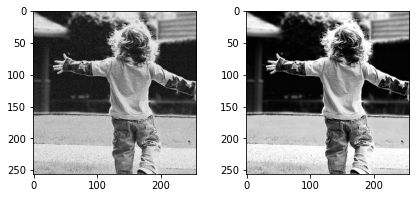

In [249]:
# %matplotlib inline

img = train_set[100]

show_multiple([img[0], img[1]])

In [250]:
'''
DnCNN
'''   
class DnCNN(nn.Module):
    def __init__(self, D, C=64):
        super(DnCNN, self).__init__()
        self.D = D
        
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(1, C, 3, padding=1))   
        for k in range(D):
            self.conv.append(nn.Conv2d(C, C, 3, padding=1))
        self.conv.append(nn.Conv2d(C, 1, 3, padding=1))    
        
        for k in range(len(self.conv)-1):
            nn.init.kaiming_normal_(self.conv[k].weight.data, nonlinearity='relu')
            
        self.bn = nn.ModuleList()
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C, C)) 
        
        for k in range(len(self.bn)):
            nn.init.constant_(self.bn[k].weight.data, 1.25 * np.sqrt(C))
        
        
    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        
        for k in range(1, D+1):
            h = F.relu(self.bn[k-1](self.conv[k](h)))
                    
        y = self.conv[D+1](h) + x
        return y

    
'''
DUDnCNN
'''    
def pad(kernel_size, dilation):
    return int(((kernel_size + (kernel_size-1)*(dilation-1))-1)/2)

class DUDnCNN(nn.Module):
    def __init__(self, D, C=64):
        super(DUDnCNN, self).__init__()
        self.D = D
        
        # CONVOLUTION MODULES
        self.conv = nn.ModuleList()
        
        self.conv.append(nn.Conv2d(1, C, 3, padding=pad(3, 1), dilation=1))
        self.conv.append(nn.Conv2d(C, C, 3, padding=pad(3, 1), dilation=1))
        
        dilation=1
        for k in range(2, int(D/2)):
            dilation *= 2
            self.conv.append(nn.Conv2d(C, C, 3, padding=pad(3, dilation), dilation=dilation))
        
        dilation = 2 ** (int(D/2)-1)
        self.conv.append(nn.Conv2d(C, C, 3, padding=pad(3, dilation), dilation=dilation))
        self.conv.append(nn.Conv2d(C, C, 3, padding=pad(3, dilation), dilation=dilation))
            
        for k in range(int(D/2+2), D+1):
            dilation = int(dilation/2)
            self.conv.append(nn.Conv2d(C, C, 3, padding=pad(3, dilation), dilation=dilation))
            
        self.conv.append(nn.Conv2d(C, 1, 3, padding=pad(3, 1), dilation=1))
        
        for k in range(len(self.conv)-1):
            nn.init.kaiming_normal_(self.conv[k].weight.data, nonlinearity='relu')
            
            
        # BATCH NORMALIZATION MODULES
        self.bn = nn.ModuleList()
        
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C, C)) 
        
        for k in range(len(self.bn)):
            nn.init.constant_(self.bn[k].weight.data, 1.25 * np.sqrt(C))
        
        
    def forward(self, x):        
        D = self.D
        
        shortcuts = []
        
        torch.backends.cudnn.benchmark=True
        
        h = F.relu(self.conv[0](x))
        shortcuts.append(h)
                
        for k in range(1, int(D/2)):
            h = F.relu(self.bn[k-1](self.conv[k](h)))
                                                
            shortcuts.append(h)
                    
        h = self.bn[int(D/2-1)](self.conv[int(D/2)](h))
        h = (self.bn[int(D/2)](self.conv[int(D/2+1)](h)) + shortcuts[-1]) / (2**0.5)
                                        
        for k in range(int(D/2+2), D+1):                        
            h = (F.relu(self.bn[k-1](self.conv[k](h))) + shortcuts[D-k]) / (2**0.5)
            
        y = self.conv[D+1](h) + x
        
        torch.backends.cudnn.benchmark=False
        
        return y

In [251]:
class Denoiser():
    def __init__(self, net, train_set, val_set, experiment_name, batch_size=4):
        self.train_set = train_set
        self.val_set = val_set
        self.batch_size = batch_size
        
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        self.train_loader = td.DataLoader(train_set, batch_size=batch_size, shuffle=True,
                                     drop_last=True, pin_memory=True)
        self.val_loader = td.DataLoader(val_set, batch_size=batch_size, shuffle=False,
                                   drop_last=True, pin_memory=True)

        self.history = []
        self.train_loss = []
        self.train_psnr = []
        
        self.net = net.to(self.device)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=1e-3)
        self.criterion = nn.MSELoss()

        output_dir = 'checkpoints/' + experiment_name
        os.makedirs(output_dir, exist_ok=True)
        self.checkpoint_path = os.path.join(output_dir, "checkpoint.pth.tar")
        self.config_path = os.path.join(output_dir, "config.txt")

        # Transfer all local arguments/variables into attributes
        locs = {k: v for k, v in locals().items() if k != 'self'}
        self.__dict__.update(locs)

        # Load checkpoint and check compatibility
        if os.path.isfile(self.config_path):
            with open(self.config_path, 'r') as f:
                if f.read()[:-1] != repr(self):
                    raise ValueError(
                        "Cannot create this experiment: "
                        "I found a checkpoint conflicting with the current setting.")
            self.load()
        else:
            self.save()

    @property
    def epoch(self):
        return len(self.history)

    def setting(self):
        return {'Net': self.net,
                'TrainSet': self.train_set,
                'ValSet': self.val_set,
                'Optimizer': self.optimizer,
                'BatchSize': self.batch_size}
    
    def __repr__(self):
        string = ''
        for key, val in self.setting().items():
            string += '{}({})\n'.format(key, val)
        return string

    def state_dict(self):
        return {'Net': self.net.state_dict(),
                'Optimizer': self.optimizer.state_dict(),
                'History': self.history,
                'TrainLoss' : self.train_loss, 
                'TrainPSNR' : self.train_psnr}

    def load_state_dict(self, checkpoint):
        self.net.load_state_dict(checkpoint['Net'])
        self.optimizer.load_state_dict(checkpoint['Optimizer'])
        
        self.history = checkpoint['History']
        self.train_loss = checkpoint['TrainLoss']
        self.train_psnr = checkpoint['TrainPSNR']

    def save(self):
        torch.save(self.state_dict(), self.checkpoint_path)
        with open(self.config_path, 'w') as f:
            print(self, file=f)

    def load(self):
        checkpoint = torch.load(self.checkpoint_path,
                                map_location=self.device)
        self.load_state_dict(checkpoint)
        del checkpoint
        
    def plot(self, fig, axes, noisy_img):
        with torch.no_grad():
            denoised = self.net(noisy_img[None].to(self.device))[0]
            
        axes[0][0].clear()
        axes[0][1].clear()
        axes[1][0].clear()
        axes[1][1].clear()
                
        myimshow(noisy_img, ax=axes[0][0])
        axes[0][0].set_title('Noisy Image')
        
        myimshow(denoised, ax=axes[0][1])
        axes[0][1].set_title('Denoised Image')
        
        axes[1][0].plot([self.train_loss[k] for k in range(self.epoch)], label='training loss')
        axes[1][0].legend(loc='upper right')
        axes[1][0].set(xlabel='Epoch', ylabel='Loss')
        
        axes[1][1].plot([self.train_psnr[k] for k in range(self.epoch)], label='training psnr')
        axes[1][1].legend(loc='lower right')
        axes[1][1].set(xlabel='Epoch', ylabel='PSNR')
        
        fig.tight_layout()
        fig.canvas.draw()
        
        
    def run(self, num_epochs):
        self.net.train()
        start_epoch = self.epoch
        print("Start/Continue training from epoch {}".format(start_epoch))
                    
        num_updates = 0
        running_loss = 0
        running_psnr = 0
        
        for epoch in range(start_epoch, num_epochs):            
            for x, d in self.train_loader:
                x, d = x.to(self.device), d.to(self.device)
                self.optimizer.zero_grad()
                y = self.net(x)
                
                loss = self.criterion(y, d)
                loss.backward()
                self.optimizer.step()
                
                with torch.no_grad():
                    num_updates += 1
                    running_loss += loss.item()
                    running_psnr += 10*torch.log10(4*len(y.reshape(-1)) / torch.norm(y-d)**2)
            
            self.history.append(epoch)
            self.train_loss.append(running_loss/num_updates)
            self.train_psnr.append(running_psnr/num_updates)
                
            print("Epoch {}, Train PSNR {} ".format(self.epoch, self.train_psnr[-1]))
            self.save()
                        
        print("Finish training for {} epochs".format(num_epochs))

    def evaluate(self):
        self.net.eval()
        
        with torch.no_grad():
            num_updates = 0
            running_loss = 0
            running_psnr = 0
            
            for x, d in self.val_loader:
                x, d = x.to(self.device), d.to(self.device)
                y = self.net(x)
                loss = self.criterion(y, d)
                
                num_updates += 1
                running_loss += loss.item()
                running_psnr += 10*torch.log10(4*len(y.reshape(-1)) / torch.norm(y-d)**2)
                        
        self.net.train()
        
        return {'loss' : running_loss/num_updates, 'psnr' : running_psnr/num_updates}

PSNR: 34.9428653717041 


Noisy             |        Clean


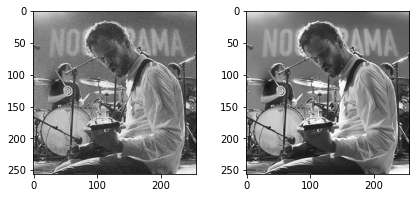

In [252]:
# %matplotlib inline

# sample clean test image
test_img = test_set[366]

# print("Norm difference:", torch.norm(test_img[0] - test_img[1]).item())
print("PSNR:", 10*torch.log10(4*len(test_img[0].reshape(-1)) / torch.norm(test_img[0]-test_img[1])**2).item(), '\n\n')
print("Noisy             |        Clean")
show_multiple([test_img[0], test_img[1]])

In [254]:
# change network type to 'DnCNN', 'UDnCNN', or 'DUDnCNN'
# to load a pre-existing environment, set experiment_name to correct checkpoint folder

network_type = 'DnCNN'
denoiser = Denoiser(net=eval(network_type)(D=6), train_set=train_set, 
                                     val_set=test_set, 
                                     experiment_name='exp1_' + train_set.root_dir + '_' + network_type, 
                    batch_size=50)


# train network
denoiser.run(num_epochs=100)

Start/Continue training from epoch 0
Epoch 1, Train PSNR 27.250289916992188 
Epoch 2, Train PSNR 29.224002838134766 
Epoch 3, Train PSNR 30.25080108642578 
Epoch 4, Train PSNR 30.903757095336914 
Epoch 5, Train PSNR 31.35971450805664 
Epoch 6, Train PSNR 31.692981719970703 
Epoch 7, Train PSNR 31.96619415283203 
Epoch 8, Train PSNR 32.17258834838867 
Epoch 9, Train PSNR 32.362709045410156 
Epoch 10, Train PSNR 32.489715576171875 
Epoch 11, Train PSNR 32.63210678100586 
Epoch 12, Train PSNR 32.72910690307617 
Epoch 13, Train PSNR 32.827430725097656 
Epoch 14, Train PSNR 32.90264892578125 
Epoch 15, Train PSNR 32.97685241699219 
Epoch 16, Train PSNR 33.05272674560547 
Epoch 17, Train PSNR 33.10954666137695 
Epoch 18, Train PSNR 33.18483352661133 
Epoch 19, Train PSNR 33.23991775512695 
Epoch 20, Train PSNR 33.29293441772461 
Epoch 21, Train PSNR 33.33628845214844 
Epoch 22, Train PSNR 33.38155746459961 
Epoch 23, Train PSNR 33.418251037597656 
Epoch 24, Train PSNR 33.45415115356445 
Epoc

KeyboardInterrupt: 

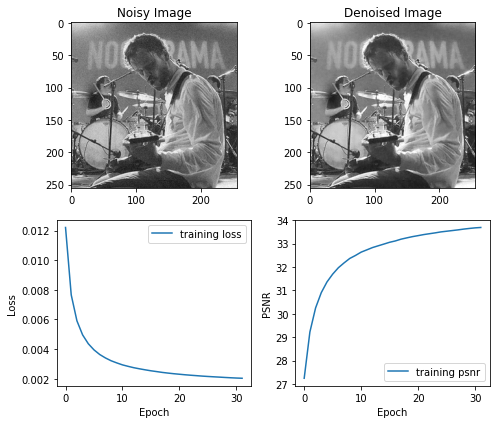

In [255]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(7,6))

denoiser.plot(fig=fig, axes=axes, noisy_img=test_img[0])

In [242]:
# evaluate performance on test set

denoiser.evaluate()

{'loss': 0.001366351100538547, 'psnr': tensor(35.0959, device='cuda:0')}

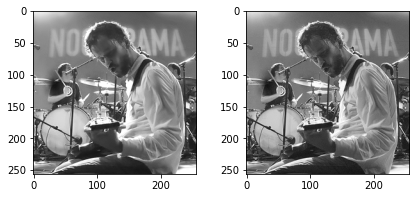

In [256]:
# %matplotlib inline

# check if clean image is broken after denoising

with torch.no_grad():
    show_multiple([denoiser.net(test_img[1][None].to(denoiser.device))[0], test_img[1]])